<a href="https://colab.research.google.com/github/SerDavidE/MoodTunes/blob/main/Automating_Moosic's_Playlist_Creation_with_Data_Science.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
file_path = '/content/drive/MyDrive/Chapter_6/df_audio_features_5000_cleaned_whitespaces.csv'
final_audio_features = pd.read_csv(file_path)

In [ ]:
final_audio_features.head()

## Distribution of Audio Features

In [3]:
# Extract the columns of interest
cols_of_interest = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
                    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

In [13]:
# Calculate variance for each of the features
variance = final_audio_features[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
                 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']].var()

variance

danceability          0.047542
energy                0.083137
key                  12.756034
loudness             39.625138
mode                  0.228661
speechiness           0.005068
acousticness          0.126725
instrumentalness      0.137408
liveness              0.022323
valence               0.077131
tempo               816.157103
dtype: float64

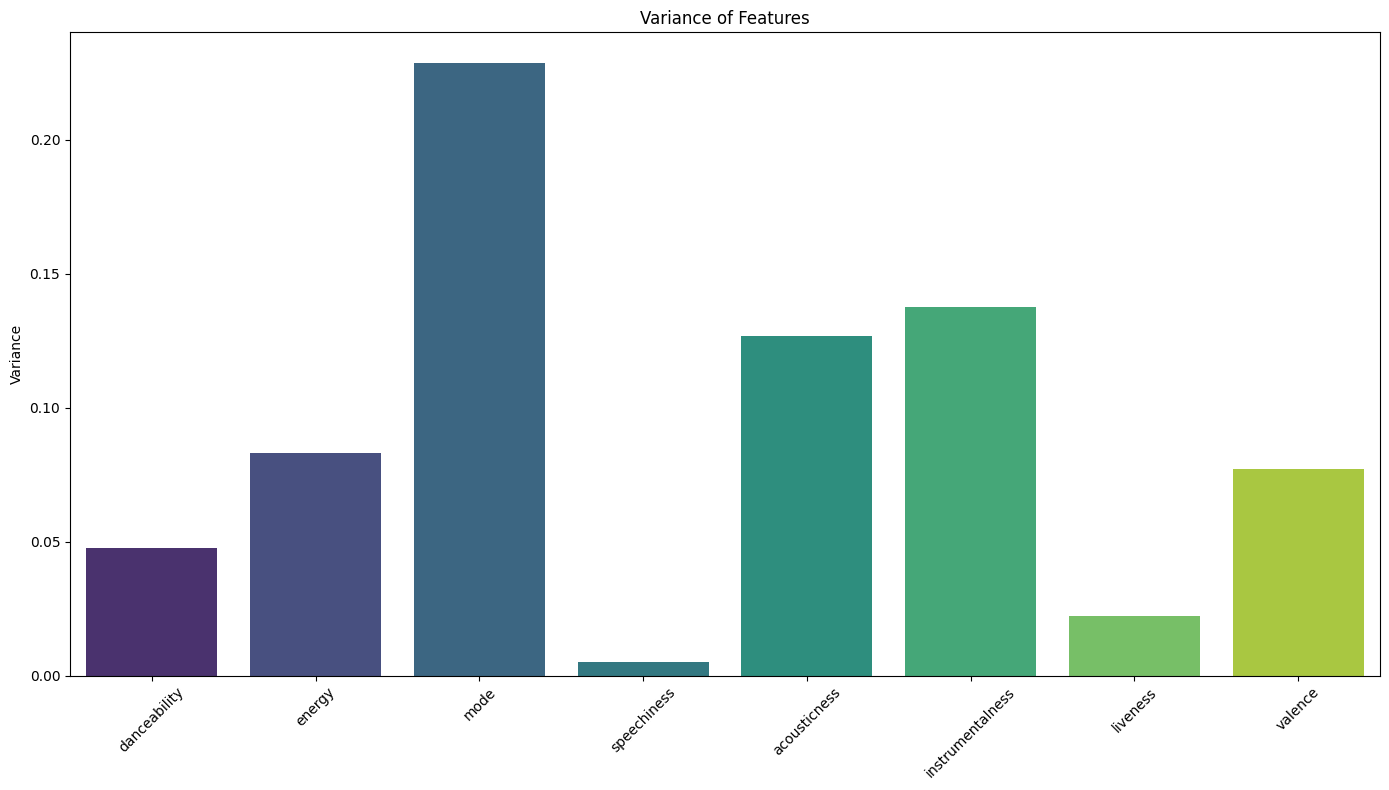

In [12]:
# Plotting the variance
plt.figure(figsize=(14, 8))
sns.barplot(x=variance.index, y=variance.values, palette="viridis")
plt.title("Variance of Features")
plt.ylabel("Variance")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

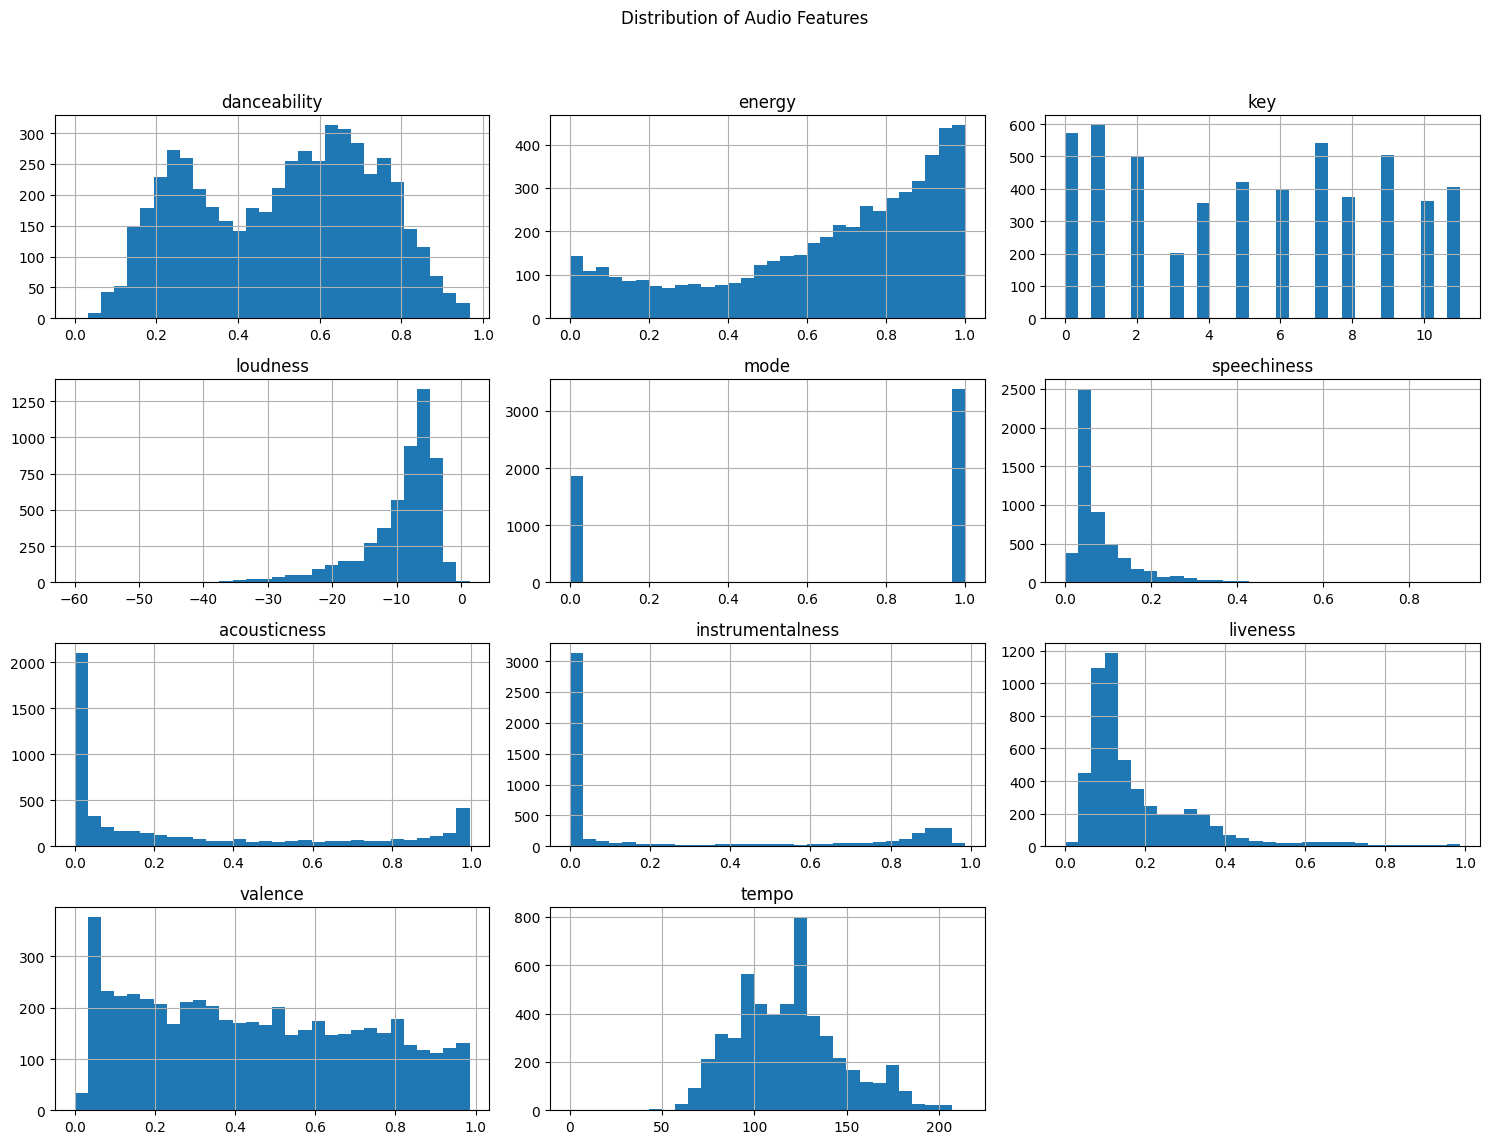

In [4]:
# Plotting histograms
final_audio_features[cols_of_interest].hist(figsize=(15, 12), bins=30)
plt.suptitle('Distribution of Audio Features')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Correlation Matrix

In [5]:
# Compute the correlation matrix for the specified columns
correlation_matrix = final_audio_features[cols_of_interest].corr()

correlation_matrix

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
danceability,1.000000,0.040491,0.002152,0.358328,-0.088908,0.036121,-0.111151,-0.573800,-0.032534,0.680097,-0.009585
energy,0.040491,1.000000,0.029702,0.786860,-0.008461,0.303940,-0.850469,-0.169923,0.170642,0.159101,0.211617
key,0.002152,0.029702,1.000000,0.027082,-0.155697,0.027547,-0.024794,-0.016775,0.025193,-0.018109,-0.002370
loudness,0.358328,0.786860,0.027082,1.000000,-0.030855,0.233609,-0.697709,-0.471786,0.134788,0.335754,0.213228
mode,-0.088908,-0.008461,-0.155697,-0.030855,1.000000,-0.041282,0.028854,-0.003017,-0.009712,0.005966,0.004739
speechiness,0.036121,0.303940,0.027547,0.233609,-0.041282,1.000000,-0.265754,-0.064754,0.081963,-0.011395,0.064255
acousticness,-0.111151,-0.850469,-0.024794,-0.697709,0.028854,-0.265754,1.000000,0.194941,-0.103144,-0.130646,-0.187994
instrumentalness,-0.573800,-0.169923,-0.016775,-0.471786,-0.003017,-0.064754,0.194941,1.000000,-0.051664,-0.500584,-0.071945
liveness,-0.032534,0.170642,0.025193,0.134788,-0.009712,0.081963,-0.103144,-0.051664,1.000000,0.007272,0.036370
valence,0.680097,0.159101,-0.018109,0.335754,0.005966,-0.011395,-0.130646,-0.500584,0.007272,1.000000,0.098783


Given the correlation matrix we've already seen, we can start by dropping features that have very high correlations (e.g., above 0.75 or below -0.75). Let's identify pairs of features with high correlations

The following pairs of features have correlations above the threshold of 0.75:

Energy and Loudness have a strong positive correlation.
Acousticness and Energy have a strong negative correlation.
Given that these features are highly correlated, they might provide redundant information when clustering.

To avoid redundancy, we can consider dropping one feature from each pair. Based on domain knowledge and the context of song characteristics:

Between Energy and Loudness, Loudness might provide more direct and interpretable information about the audio level of the track.
Between Acousticness and Energy, Acousticness provides information about the presence of acoustic sounds in the track, which might be more specific and relevant for distinguishing between tracks.
Thus, we could consider dropping Energy.

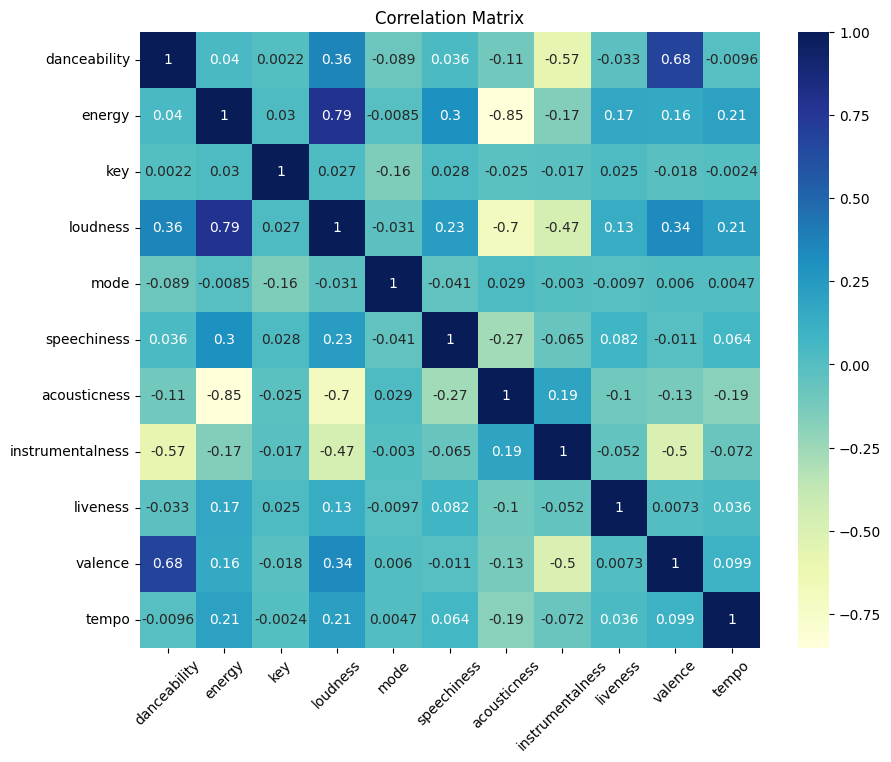

In [6]:
# Visualize the distance matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="YlGnBu", xticklabels=cols_of_interest, yticklabels=cols_of_interest)
plt.title("Correlation Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

## Data scaling

In [7]:
# Extracting relevant features for clustering
features = ['danceability', 'key', 'loudness', 'mode', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
data_for_clustering = final_audio_features[features]

In [8]:
from sklearn.preprocessing import RobustScaler

# Scaling the audio features with Robust Scaler
robust_scaler = RobustScaler()
scaled_audio_features = robust_scaler.fit_transform(data_for_clustering)

scaled_audio_features[:5]  # Displaying first 5 rows of scaled data

array([[ 3.13984169e-01,  1.00000000e+00, -9.55540919e-01,
        -1.00000000e+00,  2.46437552e-01,  1.06313826e+00,
        -2.83250838e-03,  5.88235294e+00, -2.30769231e-01,
        -2.32633109e-01],
       [ 5.35620053e-01, -5.00000000e-01, -8.74032603e-01,
         0.00000000e+00, -3.55406538e-01,  2.15966610e-01,
        -2.92087555e-03, -1.24567474e-01,  5.73804574e-01,
         1.54815696e-01],
       [ 8.23218997e-01, -5.00000000e-01, -6.10900708e-01,
         0.00000000e+00,  4.88181056e+00,  6.35112335e-01,
        -2.82519888e-03, -6.92041522e-03,  1.01455301e+00,
        -6.73325406e-01],
       [ 4.37994723e-01, -1.66666667e-01, -1.77457599e+00,
         0.00000000e+00, -1.45850796e-01,  1.39170589e+00,
        -2.86081325e-03,  1.80622837e+00,  2.22453222e-01,
        -3.27070947e-01],
       [ 2.95514512e-01,  1.66666667e-01, -2.05318623e+00,
         0.00000000e+00, -2.98407376e-01,  1.45741941e+00,
        -2.39036149e-03, -1.45328720e-01, -3.11850312e-02,
         4.

In [8]:
# Scaling the data StandarScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_clustering)

scaled_data[:5]  # Displaying the first 5 rows of scaled data

array([[ 1.60885132, -1.35154499, -0.29214747],
       [-0.91129729,  0.73989398,  0.22115982],
       [-0.91129729,  0.73989398, -0.87599383],
       [-0.35126427,  0.73989398, -0.41726241],
       [ 0.20876876,  0.73989398,  0.07770123]])

## Elbow method

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

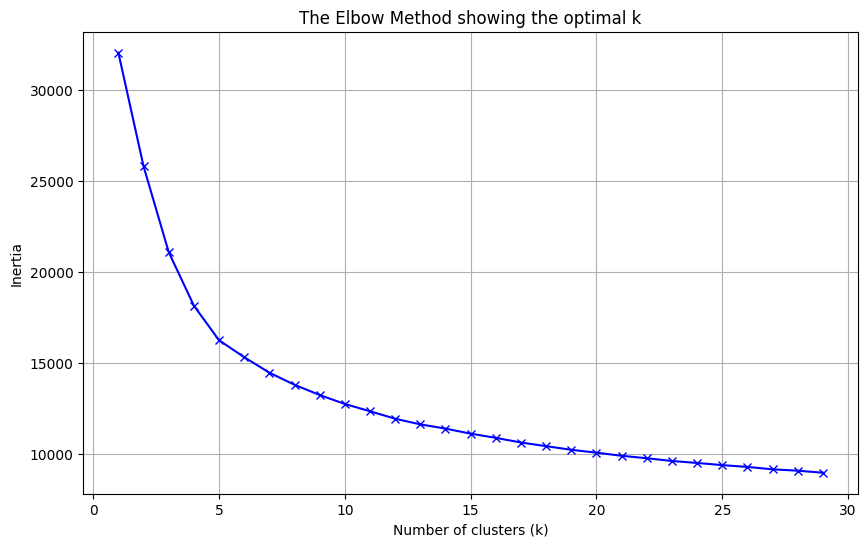

In [12]:
# Elbow method
inertia = []
K = range(1, 30)

for k in K:
    kmeanModel = KMeans(n_clusters=k)
    #kmeanModel.fit(scaled_data) # StandardScaler
    kmeanModel.fit(scaled_audio_features) # RobustScaler
    inertia.append(kmeanModel.inertia_)

# Plotting the Elbow
plt.figure(figsize=(10,6))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal k')
plt.grid(True)
plt.show()

The elbow method's plot shows a bend, which suggests the optimal number of clusters for the data. In this case, the bend appears to be around
k=4 or
k=5

## Silhouette Coefficient

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

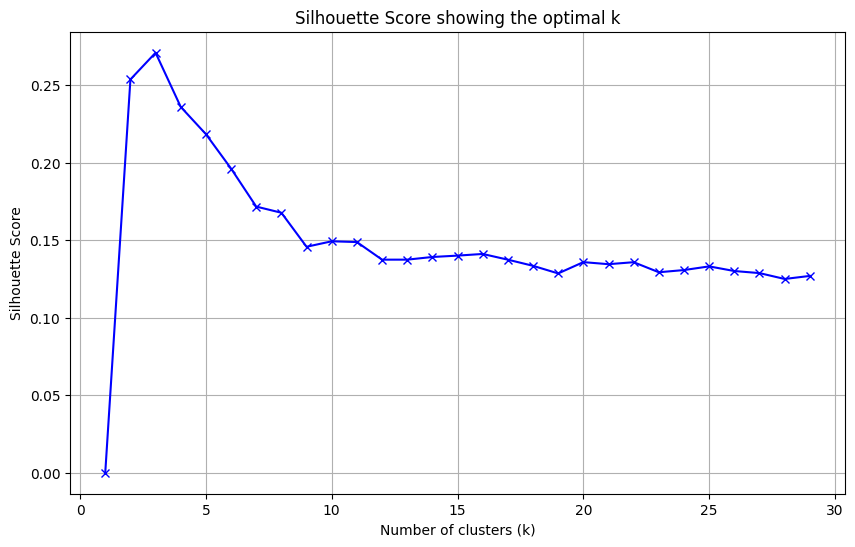

In [14]:
silhouette_scores = []

for k in K:
    kmeanModel = KMeans(n_clusters=k)
    #cluster_labels = kmeanModel.fit_predict(scaled_data) # StandardScaler
    cluster_labels = kmeanModel.fit_predict(scaled_audio_features) # RobustScaler

    # Only compute silhouette score for k > 1
    if k > 1:
        #silhouette_avg = silhouette_score(scaled_data, cluster_labels) # StandardScaler
        silhouette_avg = silhouette_score(scaled_audio_features, cluster_labels) # RobustScaler
        silhouette_scores.append(silhouette_avg)
    else:
        silhouette_scores.append(0)

# Plotting the silhouette scores
plt.figure(figsize=(10,6))
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score showing the optimal k')
plt.grid(True)
plt.show()

# K-Means final model

In [16]:
# K-Means clustering with k=5
kmeans_final = KMeans(n_clusters=5, random_state=42)
#cluster_labels = kmeans_final.fit_predict(scaled_data) #StandardScaler
cluster_labels = kmeans_final.fit_predict(scaled_audio_features)

# Assigning cluster labels to the original dataframe
final_audio_features['cluster'] = cluster_labels

# Displaying the first few rows with cluster assignments
final_audio_features.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,name,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,duration_ms,time_signature,id,html,cluster
0,Se Eu Quiser Falar Com Deus ...,Gilberto Gil,0.658,0.2590,11,-13.141,0,0.0705,0.694,0.000059,0.975,0.306,110.376,,256213,4,1n7JnwviZ7zf0LR1tcGFq7,https://open.spotify.com/track/1n7JnwviZ7zf0LR...,1
1,Saudade De Bahia ...,Antônio Carlos Jobim,0.742,0.3990,2,-12.646,1,0.0346,0.217,0.000002,0.107,0.693,125.039,,191867,4,5QGM1U0eCYrQuwSJwTm5Zq,https://open.spotify.com/track/5QGM1U0eCYrQuwS...,4
2,"Canta Canta, Minha Gente ...",Martinho Da Vila,0.851,0.7300,2,-11.048,1,0.3470,0.453,0.000063,0.124,0.905,93.698,,152267,4,0NLIFSZxPzQhCwnkn5PJYs,https://open.spotify.com/track/0NLIFSZxPzQhCwn...,2
3,Mulher Eu Sei ...,Chico César,0.705,0.0502,4,-18.115,1,0.0471,0.879,0.000041,0.386,0.524,106.802,,186227,4,3mXqOdlLE1k67WsAxryPFs,https://open.spotify.com/track/3mXqOdlLE1k67Ws...,3
4,Rosa Morena ...,Kurt Elling,0.651,0.1190,6,-19.807,1,0.0380,0.916,0.000343,0.104,0.402,120.941,,273680,4,7bSzjzjTkWT2CkIPPdp0eA,https://open.spotify.com/track/7bSzjzjTkWT2CkI...,3


In [ ]:
# Size of the Clusters base on Standar Scaler
cluster_sizes = final_audio_features['cluster'].value_counts()
cluster_sizes

In [18]:
# Size of the Clusters base on Robust Scaler
cluster_sizes = final_audio_features['cluster'].value_counts()
cluster_sizes

4    2394
0    1041
3     783
1     582
2     435
Name: cluster, dtype: int64

## Univariate exploration

The distribution of each feature within each cluster. This will give us insights into what distinguishes each cluster.

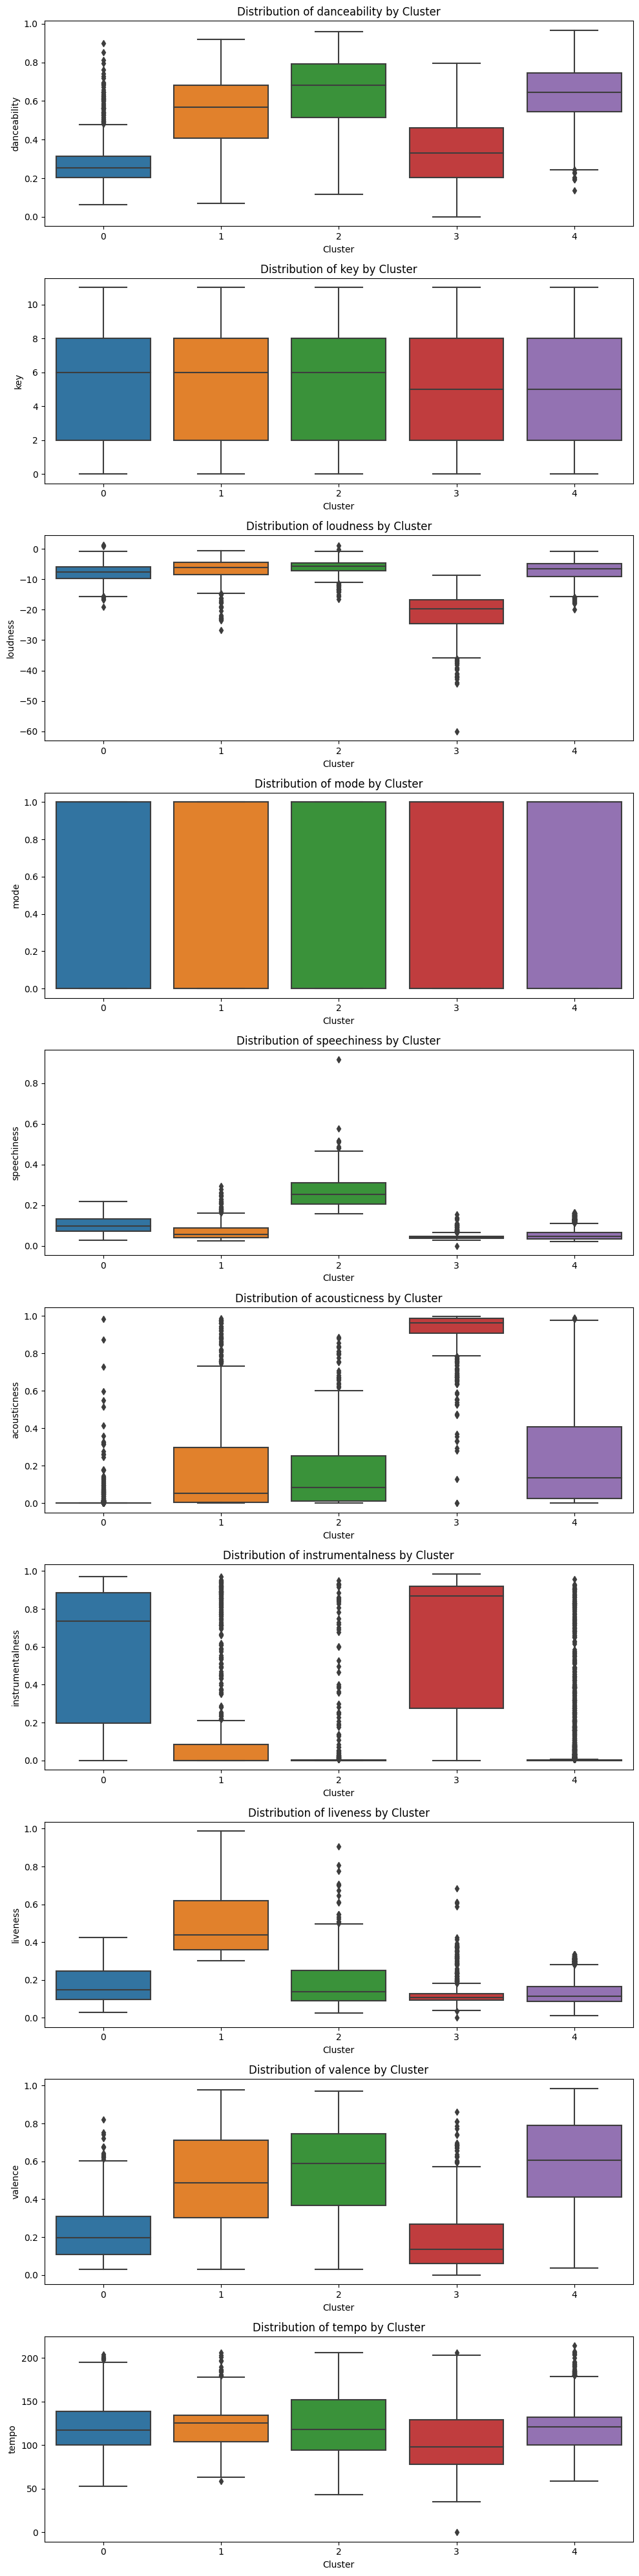

In [19]:
# Setting up the figure and axes
fig, axs = plt.subplots(len(features), 1, figsize=(10, 40))

# Plotting univariate distributions for each feature by cluster
for idx, feature in enumerate(features):
    sns.boxplot(x='cluster', y=feature, data=final_audio_features, ax=axs[idx])
    axs[idx].set_title(f'Distribution of {feature} by Cluster')
    axs[idx].set_ylabel(f'{feature}')
    axs[idx].set_xlabel('Cluster')

plt.tight_layout()
plt.show()

Danceability: Cluster 3 appears to have higher danceability compared to other clusters.

Key: There's some variation in musical key across clusters, but there's overlap too.

Loudness: Cluster 3 tends to be louder, while Cluster 0 has the quietest songs.

Mode: Cluster 4 seems to have a higher concentration of minor mode songs.

Speechiness: Cluster 2 and 3 have more tracks with higher speechiness.

Acousticness: Cluster 4 is more acoustic, while Cluster 3 is the least.

Instrumentalness: Cluster 0 and 2 have more instrumental tracks.

Liveness: Cluster 4 shows a higher concentration of live recordings.

Valence: Cluster 3 tends to have songs with higher valence (more positive),
while Cluster 4 has songs with lower valence.

Tempo: Cluster 3 has faster-paced songs, while Cluster 0 tends to have slower songs.

From these observations, we can infer specific characteristics about each cluster, which will help in manual labeling. For instance, Cluster 3 seems to be more upbeat and energetic, while Cluster 4 may be more acoustic and live.

## Bivariately  observation

Given the number of features, there are numerous possible combinations. To keep things manageable, let's focus on a few potentially informative combinations:

Danceability vs. Valence

Acousticness vs. Loudness

Tempo vs. Liveness

Speechiness vs. Instrumentalness

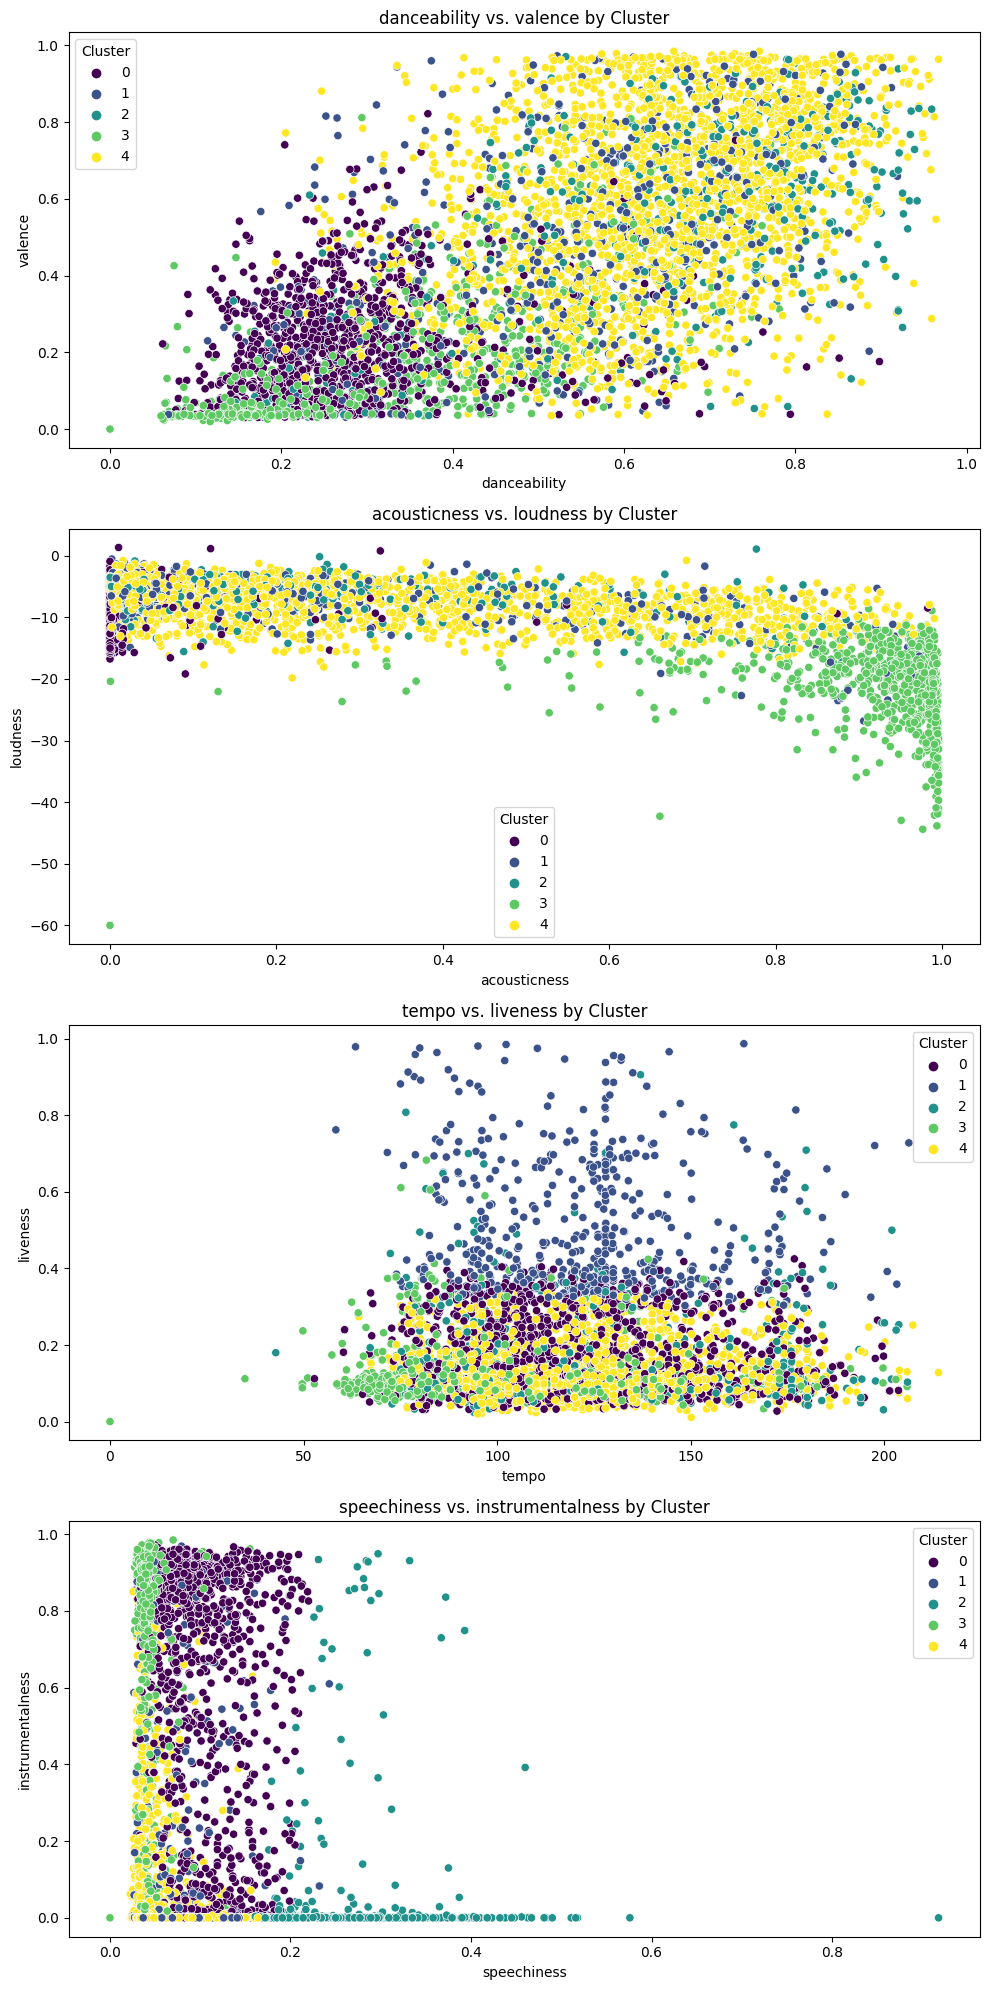

In [20]:
# Selected feature pairs for bivariate exploration
feature_pairs = [('danceability', 'valence'),
                 ('acousticness', 'loudness'),
                 ('tempo', 'liveness'),
                 ('speechiness', 'instrumentalness')]

# Setting up the figure and axes
fig, axs = plt.subplots(len(feature_pairs), 1, figsize=(10, 20))

# Plotting scatter plots for each feature pair
for idx, (x_feature, y_feature) in enumerate(feature_pairs):
    sns.scatterplot(x=x_feature, y=y_feature, hue='cluster', data=final_audio_features, ax=axs[idx], palette='viridis')
    axs[idx].set_title(f'{x_feature} vs. {y_feature} by Cluster')
    axs[idx].set_ylabel(f'{y_feature}')
    axs[idx].set_xlabel(f'{x_feature}')
    axs[idx].legend(title='Cluster')

plt.tight_layout()
plt.show()

Danceability vs. Valence:

Cluster 3 shows high danceability and valence, indicating these tracks might be upbeat and positive.
Cluster 4 exhibits a wide range of danceability but lower valence, suggesting tracks that might be varied in rhythm but generally more melancholic.

Acousticness vs. Loudness:

Cluster 4 has higher acousticness and lower loudness, indicating these might be quieter, more acoustic tracks.
Cluster 3 exhibits lower acousticness and higher loudness, suggesting these are louder, less acoustic tracks.

Tempo vs. Liveness:

Cluster 3 has a range of liveness values but is concentrated in the higher tempo region, suggesting these tracks are faster-paced.
Cluster 4 has a wider spread in tempo but is concentrated in the higher liveness region, indicating more live recordings.
Clusters 0, 1, and 2 have a mix of tempo and liveness values but don't show a strong specific trend.

Speechiness vs. Instrumentalness:

Cluster 2 has higher speechiness, suggesting these might contain more spoken words or rap.
Cluster 0 exhibits higher instrumentalness, indicating these are more instrumental tracks.


# Manual Labeling

Based on the univariate and bivariate explorations, as well as the inherent characteristics of the audio features, let's attempt to provide descriptive labels to the clusters:

1. **Cluster 0**:
    - Features: Higher instrumentalness, range of tempo values.
    - Label: **Instrumental Tracks**

2. **Cluster 1**:
    - Features: Moderate values for most features, without any significant distinguishing characteristics.
    - Label: **General Mix**

3. **Cluster 2**:
    - Features: Higher speechiness, suggesting these might contain more spoken words or rap.
    - Label: **Speech/Rap Tracks**

4. **Cluster 3**:
    - Features: High danceability, high valence, louder tracks, and higher tempo.
    - Label: **Upbeat & Energetic Tracks**

5. **Cluster 4**:
    - Features: Higher acousticness, more live recordings, and a range of danceability but generally lower valence.
    - Label: **Acoustic & Live Tracks**

These labels are based on the characteristics we observed in the clusters, and they provide a general idea of the type of songs in each cluster. The labels can be refined further based on more in-depth analysis, domain knowledge, or listening to a sample of songs from each cluster.

# Assigning the manual labels to the clusters

In [21]:
cluster_labels = {
    0: 'Instrumental Tracks',
    1: 'General Mix',
    2: 'Speech/Rap Tracks',
    3: 'Upbeat & Energetic Tracks',
    4: 'Acoustic & Live Tracks'
}

final_audio_features['cluster_label'] = final_audio_features['cluster'].map(cluster_labels)

# Displaying the first few rows with cluster labels
final_audio_features.head()

,name,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,duration_ms,time_signature,id,html,cluster,cluster_label
0,Se Eu Quiser Falar Com Deus ...,Gilberto Gil,0.658,0.2590,11,-13.141,0,0.0705,0.694,0.000059,0.975,0.306,110.376,,256213,4,1n7JnwviZ7zf0LR1tcGFq7,https://open.spotify.com/track/1n7JnwviZ7zf0LR...,1,General Mix
1,Saudade De Bahia ...,Antônio Carlos Jobim,0.742,0.3990,2,-12.646,1,0.0346,0.217,0.000002,0.107,0.693,125.039,,191867,4,5QGM1U0eCYrQuwSJwTm5Zq,https://open.spotify.com/track/5QGM1U0eCYrQuwS...,4,Acoustic & Live Tracks
2,"Canta Canta, Minha Gente ...",Martinho Da Vila,0.851,0.7300,2,-11.048,1,0.3470,0.453,0.000063,0.124,0.905,93.698,,152267,4,0NLIFSZxPzQhCwnkn5PJYs,https://open.spotify.com/track/0NLIFSZxPzQhCwn...,2,Speech/Rap Tracks
3,Mulher Eu Sei ...,Chico César,0.705,0.0502,4,-18.115,1,0.0471,0.879,0.000041,0.386,0.524,106.802,,186227,4,3mXqOdlLE1k67WsAxryPFs,https://open.spotify.com/track/3mXqOdlLE1k67Ws...,3,Upbeat & Energetic Tracks
4,Rosa Morena ...,Kurt Elling,0.651,0.1190,6,-19.807,1,0.0380,0.916,0.000343,0.104,0.402,120.941,,273680,4,7bSzjzjTkWT2CkIPPdp0eA,https://open.spotify.com/track/7bSzjzjTkWT2CkI...,3,Upbeat & Energetic Tracks


# Posting clusters to Spotify

## Creating Clusters with KMeans

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import set_config
set_config(transform_output='pandas')

In [23]:
# Explore individual clusters
final_audio_features.loc[final_audio_features.cluster == 2].head()

,name,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,duration_ms,time_signature,id,html,cluster,cluster_label
2,"Canta Canta, Minha Gente ...",Martinho Da Vila,0.851,0.730,2,-11.048,1,0.347,0.453,0.000063,0.1240,0.905,93.698,,152267,4,0NLIFSZxPzQhCwnkn5PJYs,https://open.spotify.com/track/0NLIFSZxPzQhCwn...,2,Speech/Rap Tracks
7,O Meu Amor É Glòria ...,Sílvia Pérez Cruz,0.504,0.733,7,-10.720,1,0.389,0.696,0.000056,0.6730,0.886,96.565,,309760,4,0ylJQpV3K4XnhWhLDMFmH7,https://open.spotify.com/track/0ylJQpV3K4XnhWh...,2,Speech/Rap Tracks
26,Karoliina Kaunis ...,Maria Gasolina,0.753,0.215,11,-15.671,0,0.293,0.618,0.004640,0.0912,0.382,130.338,,251427,4,7BlLxHwobm2gHjXev9dNVe,https://open.spotify.com/track/7BlLxHwobm2gHjX...,2,Speech/Rap Tracks
28,Aquarela Do Brasil ...,Gal Costa,0.553,0.550,1,-13.401,1,0.398,0.800,0.000723,0.9060,0.679,137.016,,206413,4,1wo6p8AMWXREZVowQCa4BC,https://open.spotify.com/track/1wo6p8AMWXREZVo...,2,Speech/Rap Tracks
122,Vai (Menina amanhã de manhã) ...,Tom Zé,0.671,0.630,5,-10.367,1,0.237,0.885,0.000000,0.1320,0.794,127.645,,175133,4,5OjDD3tZErNCn5QqqpJmKf,https://open.spotify.com/track/5OjDD3tZErNCn5Q...,2,Speech/Rap Tracks


## Clustering Songs for Spotify Playlists

### Getting Started with Spotify
The following Python code implements a clustering algorithm for creating Spotify playlists based on song features. The idea is to create a unique set of songs that are representative of various musical clusters.

Before we begin with clustering, let us take a look at how we can post chosen songs to Spotify. To begin, we'll need to navigate to Spotify's Developer Website, register and hit the button to Create app. Give your app a name and brief description, and enter a Redirect URI.

For Google Colab we set the RedirectURL to http://localhost:8081/

In [25]:
!pip install spotipy
# OR
# !conda install -c conda-forge spotipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.1/250.1 kB 5.1 MB/s eta 0:00:00


In [33]:
import spotipy
import pickle
from spotipy.oauth2 import SpotifyOAuth

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
import key_MFC

In [40]:
scope = 'playlist-modify-public'
username = key_MFC.username
redirectUri = key_MFC.redirectUri
client_id = key_MFC.client_id
client_secret = key_MFC.client_secret

token = SpotifyOAuth(scope=scope,
                     username=username,
                     client_id=client_id,
                     client_secret=client_secret,
                     redirect_uri=redirectUri,
                     open_browser=False # this line is need in Colab, but not on local machine
                     )
spotifyObject = spotipy.Spotify(auth_manager = token)

In [41]:
playlist_collection = {}
for i in range(5):
    playlist_name = f'my_playlist_cluster_{i}'
    playlist_description= 'this is a test list'
    playlist_id = spotifyObject.user_playlist_create(user=username,
                                                     name=playlist_name,
                                                     public=True,
                                                     description=playlist_description)['id']
    id_list = list(final_audio_features.loc[final_audio_features["cluster"] == i]
                                .sample(5)
                                .id)
    uris = [f'spotify:track:{str(id).strip()}' for id in id_list]
    spotifyObject.user_playlist_add_tracks(user=username,playlist_id=playlist_id,tracks=uris)
    playlist_collection[playlist_name] = playlist_id

Go to the following URL: https://accounts.spotify.com/authorize?client_id=8ff72d83ec4e4655a2d9adb5665946e6&response_type=code&redirect_uri=http%3A%2F%2Flocalhost%3A8081%2Fcallback&scope=playlist-modify-public
Enter the URL you were redirected to: http://localhost:8081/callback?code=AQDIS9UKNgzEixeVT5zIgFwmvISDpMKCDPAI_BHGiU5nubNp4wOmxAkpsZzhdMH13f2PdBemIcocAHWgNqgh9nxkpwMOVpyZD9LQy5PtRPvOCFtCnlH7sXa-DAUSlqYLOZIFFjsBFwNNyvWvOzoBAW6Mis9oLvA71zGrJeQy82nFtB3acyKPxFg2rKAWPOz7d3QkeZJo7F52nA


In [42]:
with open("./playlists.pkl", "wb") as f:
    pickle.dump(playlist_collection, f)
from google.colab import files
files.download("./playlists.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Later iterations

As successive iterations of the model are refined, you may wish to repopulate your lists, rather than creating an unending legion of new ones.

It is important in this case to save the `playlist_id`s created above, either as a pickled object or written to a text file.

In [ ]:
import pandas as pd
import spotipy
import pickle
from spotipy.oauth2 import SpotifyOAuth
import keys_MFC

In [ ]:
url = "https://drive.google.com/file/d/1Q32l5eGrprLgqZ4mRLStNn3VFXeO4A0M/view?usp=drive_link"
path = f"https://drive.google.com/uc?export=download&id={url.split('/')[-2]}"
songs = pd.read_csv(path)
songs.columns = songs.columns.str.strip()
songs = songs.drop("type", axis=1)
songs

,name,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,id,html
0,Se Eu Quiser Falar Com Deus ...,Gilberto Gil,0.6580,0.25900,11,-13.141,0,0.0705,0.694,0.000059,0.9750,0.3060,110.376,256213,4,1n7JnwviZ7zf0LR1tcGFq7,https://open.spotify.com/track/1n7JnwviZ7zf0LR...
1,Saudade De Bahia ...,Antônio Carlos Jobim,0.7420,0.39900,2,-12.646,1,0.0346,0.217,0.000002,0.1070,0.6930,125.039,191867,4,5QGM1U0eCYrQuwSJwTm5Zq,https://open.spotify.com/track/5QGM1U0eCYrQuwS...
2,"Canta Canta, Minha Gente ...",Martinho Da Vila,0.8510,0.73000,2,-11.048,1,0.3470,0.453,0.000063,0.1240,0.9050,93.698,152267,4,0NLIFSZxPzQhCwnkn5PJYs,https://open.spotify.com/track/0NLIFSZxPzQhCwn...
3,Mulher Eu Sei ...,Chico César,0.7050,0.05020,4,-18.115,1,0.0471,0.879,0.000041,0.3860,0.5240,106.802,186227,4,3mXqOdlLE1k67WsAxryPFs,https://open.spotify.com/track/3mXqOdlLE1k67Ws...
4,Rosa Morena ...,Kurt Elling,0.6510,0.11900,6,-19.807,1,0.0380,0.916,0.000343,0.1040,0.4020,120.941,273680,4,7bSzjzjTkWT2CkIPPdp0eA,https://open.spotify.com/track/7bSzjzjTkWT2CkI...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5230,"1812 Festival Overture, Op. 49: 1812 Overture,...",Pyotr Ilyich Tchaikovsky,0.2020,0.06940,3,-23.390,1,0.0473,0.917,0.715000,0.0832,0.0655,87.906,995000,4,1aEhYlZtypmipA06SDJ4U3,https://open.spotify.com/track/1aEhYlZtypmipA0...
5231,"Winter Fragments pour ensemble instrumental, s...",Tristan Murail,0.1880,0.10100,6,-21.873,1,0.0442,0.855,0.426000,0.0694,0.0355,83.134,855000,4,1Gfqe7TAKklmuZf6hxsH6h,https://open.spotify.com/track/1Gfqe7TAKklmuZf...
5232,"Schoenberg: 5 Orchestral Pieces, Op. 16: No. 3...",Arnold Schoenberg,0.0596,0.00093,9,-42.959,1,0.0434,0.951,0.969000,0.0772,0.0344,71.573,238187,3,2XNwnFrdMDpismp0VUZ7cU,https://open.spotify.com/track/2XNwnFrdMDpismp...
5233,"Serenade For Strings In E, Op.22, B. 52: 1. Mo...",Antonín Dvořák,0.1330,0.02080,4,-29.443,1,0.0419,0.883,0.505000,0.1110,0.0591,67.109,314307,4,7ucDwgMtE3YJtEfTbuRhy0,https://open.spotify.com/track/7ucDwgMtE3YJtEf...


In [ ]:
scope = 'playlist-modify-public'
username = keys_MFC.username
redirectUri = keys_MFC.redirect_uri
client_id = keys_MFC.client_id
client_secret = keys_MFC.client_secret

token = SpotifyOAuth(scope=scope,
                     username=username,
                     client_id=client_id,
                     client_secret=client_secret,
                     redirect_uri=redirectUri,
                     open_browser=False # this line is need in Colab, but not on local machine
                     )
spotifyObject = spotipy.Spotify(auth_manager = token)

In [ ]:
with open("./playlists.pkl", "rb") as f:
    playlist_collection = pickle.load(f)
uris = [f'spotify:track:{str(id).strip()}' for id in songs.sample(10).id]
playlist_id = playlist_collection["my_playlist_cluster_0"]
spotifyObject.user_playlist_replace_tracks(user=username, playlist_id=playlist_id, tracks=uris)

{'snapshot_id': 'NCw0ZmEzMjM4OGVlODhhOThmZjQ5YmE2MTczOWY4Yjk3YTNhNmNiM2Ey'}